In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Smooth Parameter Variation
=====================================

This tutorial shows how to smoothly vary simulation parameters as a function of time. 

It is specifically aimed at a predetermined variation, that is a temporal variation defined
by a function that does not depend on the system's state.

On the other hand, if what you want to achieve is a state dependent variation, then the
better, more efficient, approach is to define a new Model of local dynamics where the 
"parameter" you wish to vary is recast as a state-variable.

Setup and Simulator
--------------------

As usual, we'll geet started by loading some stuff through "lab".

In [2]:
from tvb.simulator.lab import *

And then, we simply construct and configure a Region level Simulator:

In [3]:
#Initialise a Model, Coupling, and Connectivity.
oscillator = models.Generic2dOscillator()
white_matter = connectivity.Connectivity(load_default=True)
white_matter.speed = numpy.array([4.0])
white_matter_coupling = coupling.Linear(a=0.0154)

#Initialise an Integrator
heunint = integrators.HeunDeterministic(dt=2**-6)

#Initialise some Monitors with period in physical time
mon_raw = monitors.Raw()
mon_tav = monitors.TemporalAverage(period=2**-2)

#Bundle them
what_to_watch = (mon_raw, mon_tav)

#Initialise a Simulator -- Model, Connectivity, Integrator, and Monitors.
sim = simulator.Simulator(model = oscillator, 
                          connectivity = white_matter,
                          coupling = white_matter_coupling, 
                          integrator = heunint, 
                          monitors = what_to_watch)
sim.configure()

Simulator(bound=False, value=None)

Temporal Parameter Variation
-----------------------------

To define the parameter's time course we'll need to specify upfront how long 
a block of simulation we're going to run.

In [4]:
sim_len = 2.0**7

We can use TVB's Equations datatype to create a Gaussian that peaks half 
way through our simulation. 

In [5]:
# Define a variation of a model parameter as a function of time using an Equation datatype
t =  numpy.arange(0, sim_len, sim.integrator.dt)

eqn_t = equations.Gaussian()
eqn_t.parameters["amp"] = 4.2
eqn_t.parameters["midpoint"] = sim_len / 2.0
eqn_t.pattern = t
a = eqn_t.pattern

#Make it a variation relative to the default value
a = sim.model.a + a

# Grab the length of what we just created, as we'll need it below
par_len = a.shape[0]

Let's take a quick look at the parameter variation we just defined, to make sure it looks like what we want...

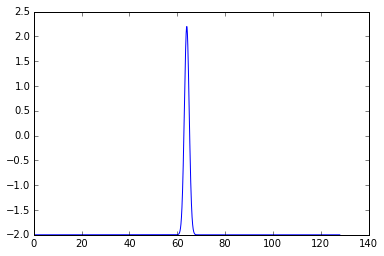

In [6]:
#Plot the stimulus
plot(t, a)

Simulate
--------

Initialise some empty lists that will contain results of the simulation

In [7]:
raw_data, raw_time = [], []
tavg_data, tavg_time = [], []

We then run the simulation, much as we normally would, just with an explicit extra
step of updating our Model parameter at each step of the integration.

**Note:** The use of sim.current_step and the modulo (%) operator here is just to 
    make it easier for us to rerun this block later, see below.

In [8]:
#Run the simulation
step = sim.current_step
sim.model.a = a[step%par_len]

for raw, tavg in sim(simulation_length = sim_len):
    
    if not raw is None:
        raw_time.append(raw[0])
        raw_data.append(raw[1])
    
    if not tavg is None:
        tavg_time.append(tavg[0])
        tavg_data.append(tavg[1])
        
    step += 1
    # Change a model parameter at each integration step
    sim.model.a = a[step%par_len]

Plots
-----

Now let's plot the resulting time-series with the parameter variation over-plotted for reference.

IndexError: index 1 is out of bounds for axis 1 with size 1

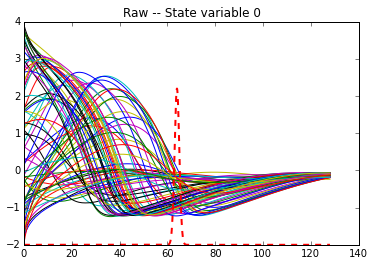

In [9]:
#Make the lists numpy.arrays for easier use.
RAW = numpy.array(raw_data)
TAVG = numpy.array(tavg_data)

#Plot raw time series
figure(1)
plot(raw_time, RAW[:, 0, :, 0])
plot(t + (step-par_len)*sim.integrator.dt, a, 'r--', linewidth=2)
title("Raw -- State variable 0")

figure(2)
plot(raw_time, RAW[:, 1, :, 0])
plot(t + (step-par_len)*sim.integrator.dt, a, 'r--', linewidth=2)
title("Raw -- State variable 1")

#Plot temporally averaged time series + parameter
figure(3)
plot(tavg_time, TAVG[:, 0, :, 0])
plot(t + (step-par_len)*sim.integrator.dt, a, 'r--', linewidth=2)
title("Temporal average")

#Show them
show()

The red dashed line is an over-plot of the stimulus on the simulated neural activity.
The response of the parameter variation is visible, if you look closely, but is mostly 
overwhelmed by the transient from our initial conditions. If you want to see the effect 
of the parameter variation more clearly, simply go back and re-evaluate the cell that 
runs the simulation, this will continue the simulation from where it finished and 
once again apply the parameter variation half way through the block of simulation.
Then simply evaluate the plotting cell again. Whether or not you evaluate the cell above 
the simulation cell again is up to you, if you do then the previously Monitored data will
be cleared (data shown in the figures), if not then the newly Monitored data will be appended to the data from 
the previous simulation run.

That's All Folks... so, what's next?
------------------------------------